1. Function to sample images with a moving window
2. Function to and align stack images

In [37]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import io
import time

In [21]:
# load image
test_path = 'Images/ppltest.jpg'
img_test = plt.imread(test_path)
print(img_test.shape)

(1745, 1014, 4)


Images are loaded in with RGB color paths

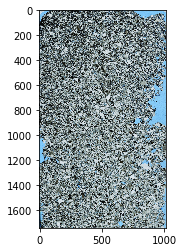

In [22]:
# show image
plt.imshow(img_test)

In [6]:
type(img_test)

numpy.ndarray

In [23]:
# load image
pil_img = Image.open(test_path).convert('RGB')
# print image dimensions
print(pil_img.size)

(1014, 1745)


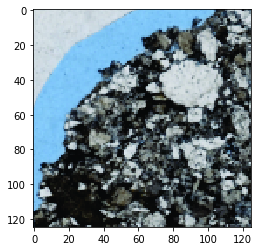

In [24]:
slice = pil_img.crop([0,0]+[125,125])
plt.imshow(slice)

In [56]:
# slices will be 150 x 150 pixels, so figure out how to slice with those dimensions
# ~30% overlap of each slice
# max number of horizontal slices will be (width-150)//50 

# dimensions for slices
width = 150
height = 150
inc = 50

topleft = [0,0]
botright = [width,height]
# increment for x and y to change topleft and botright values
xinc = inc
yinc = inc
# number of x slices to take and number of y slices to take
xi = (pil_img.size[0]-width)//inc
yi = (pil_img.size[0]-height)//inc

ppl_path = 'Images/ppltest.jpg'
xpl_path = 'Images/xpltest.png'

# load images
ppl = Image.open(ppl_path).convert('RGB')
xpl = Image.open(xpl_path).convert('RGB')

columns = ['r_ppl','g_ppl','b_ppl', 'r_xpl','g_xpl','b_xpl','rotation','topleft']
# create dataframe to hold the image slices
# columns will be red, blue, green color channels and greyscale value.
df = pd.DataFrame(columns = columns)

In [57]:
def sample_img(df, ppl, xpl, width = 150, height = 150, inc = 50, status = False):
    '''
    Function samples image and stores RGB and greyscale color channels in dataframe.
    Assumed ppl and xpl images are the same size.
    ''' 
    width = width
    height = height
    inc = inc
    
    start = time.time()

    topleft = [0,0]
    botright = [width,height]
    # increment for x and y to change topleft and botright values
    xinc = inc
    yinc = inc
    # number of x slices to take and number of y slices to take
    xi = (ppl.size[0]-width)//inc
    yi = (ppl.size[1]-height)//inc
    
    # dictionary to hold orientations and their pairs
    orientations = {'leftright': Image.FLIP_LEFT_RIGHT,
                   'topbottom': Image.FLIP_TOP_BOTTOM}
    
    # iterate through each sliding window along the height of the image
    for y in np.arange(yi):
        for x in np.arange(xi):
            
            # select orientation of image
            for orientation in [0, 1, 2]:
                if orientation == 0:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright)
                    xpl_slice = xpl.crop(topleft+botright) 
                elif orientation == 1:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                    xpl_slice = xpl.crop(topleft+botright).transpose(Image.FLIP_LEFT_RIGHT)
                else:
                    # isolate a crop of the original images
                    ppl_slice = ppl.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)
                    xpl_slice = xpl.crop(topleft+botright).transpose(Image.FLIP_TOP_BOTTOM)

                # for each slice, rotate 90 degrees up to 270 to get 4 orientations of each slice
                for rotation in [0, 90, 180, 270]:
                    ppl_slice = ppl_slice.rotate(rotation)
                    xpl_slice = xpl_slice.rotate(rotation)
                    # split RGB color channels
                    ppl_red, ppl_green, ppl_blue = ppl_slice.split()
                    xpl_red, xpl_green, xpl_blue = xpl_slice.split()
                    # put all colors into dataframe row
                    df_slice = pd.DataFrame([[np.array(ppl_red), np.array(ppl_green), np.array(ppl_blue), 
                                              np.array(xpl_red), np.array(xpl_green), np.array(xpl_blue),
                                              rotation, topleft]], columns = columns)
                    #append to main dataframe
                    df = df.append(df_slice, ignore_index = True)
            
            # shift sliding window
            topleft[0] += 100
            botright[0] += 100
            
        # reset sample box to left side of image
        topleft[0] = 0
        botright[0] = width
        # shift sample box down 100 pixels
        topleft[1] += 100
        botright[1] += 100
        
    if status == True:
        end = time.time()
        print(f'Runtime for data collection is {round(end - start,2)} seconds for {len(df)} samples')
    
    return df

def show_img(df, row):
    '''
    Function to display a slice from the dataframe
    '''
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(np.dstack((df['r_ppl'][row], df['g_ppl'][row], df['b_ppl'][row])))
    plt.subplot(1,2,2)
    plt.imshow(np.dstack((df['r_xpl'][row], df['g_xpl'][row], df['b_xpl'][row])))
    return

In [58]:
df = sample_img(df, ppl, xpl, status=True)

Runtime for data collection is 29.65 seconds for 6324 samples


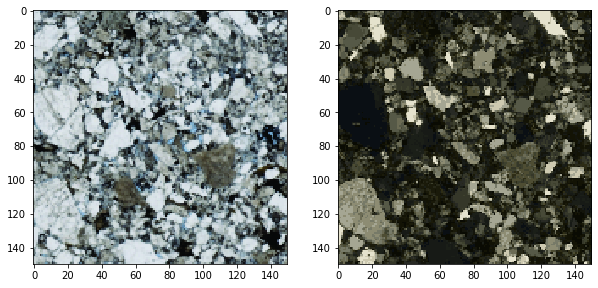

In [35]:
show_img(df, 500)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2108 entries, 0 to 2107
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   r_ppl        2108 non-null   object
 1   g_ppl        2108 non-null   object
 2   b_ppl        2108 non-null   object
 3   r_xpl        2108 non-null   object
 4   g_xpl        2108 non-null   object
 5   b_xpl        2108 non-null   object
 6   orientation  2108 non-null   object
 7   topleft      2108 non-null   object
dtypes: object(8)
memory usage: 131.9+ KB


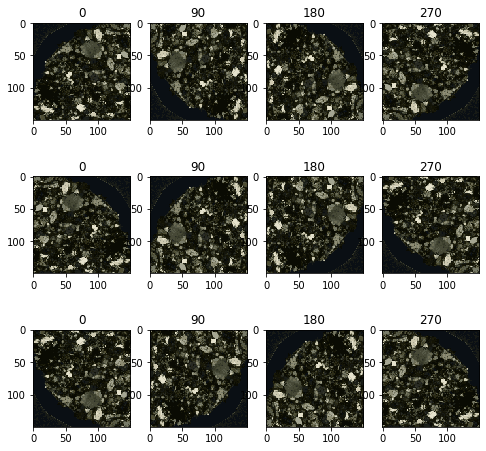

In [59]:
# show all orientations for a single slice
plt.figure(figsize=(8,8))
for i in np.arange(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.dstack((df['r_xpl'][i], df['g_xpl'][i], df['b_xpl'][i])))
    plt.title(df['rotation'][i])

In [60]:
labels_path = 'Images/labels.png'

# load images
labels = Image.open(labels_path).convert('RGB')

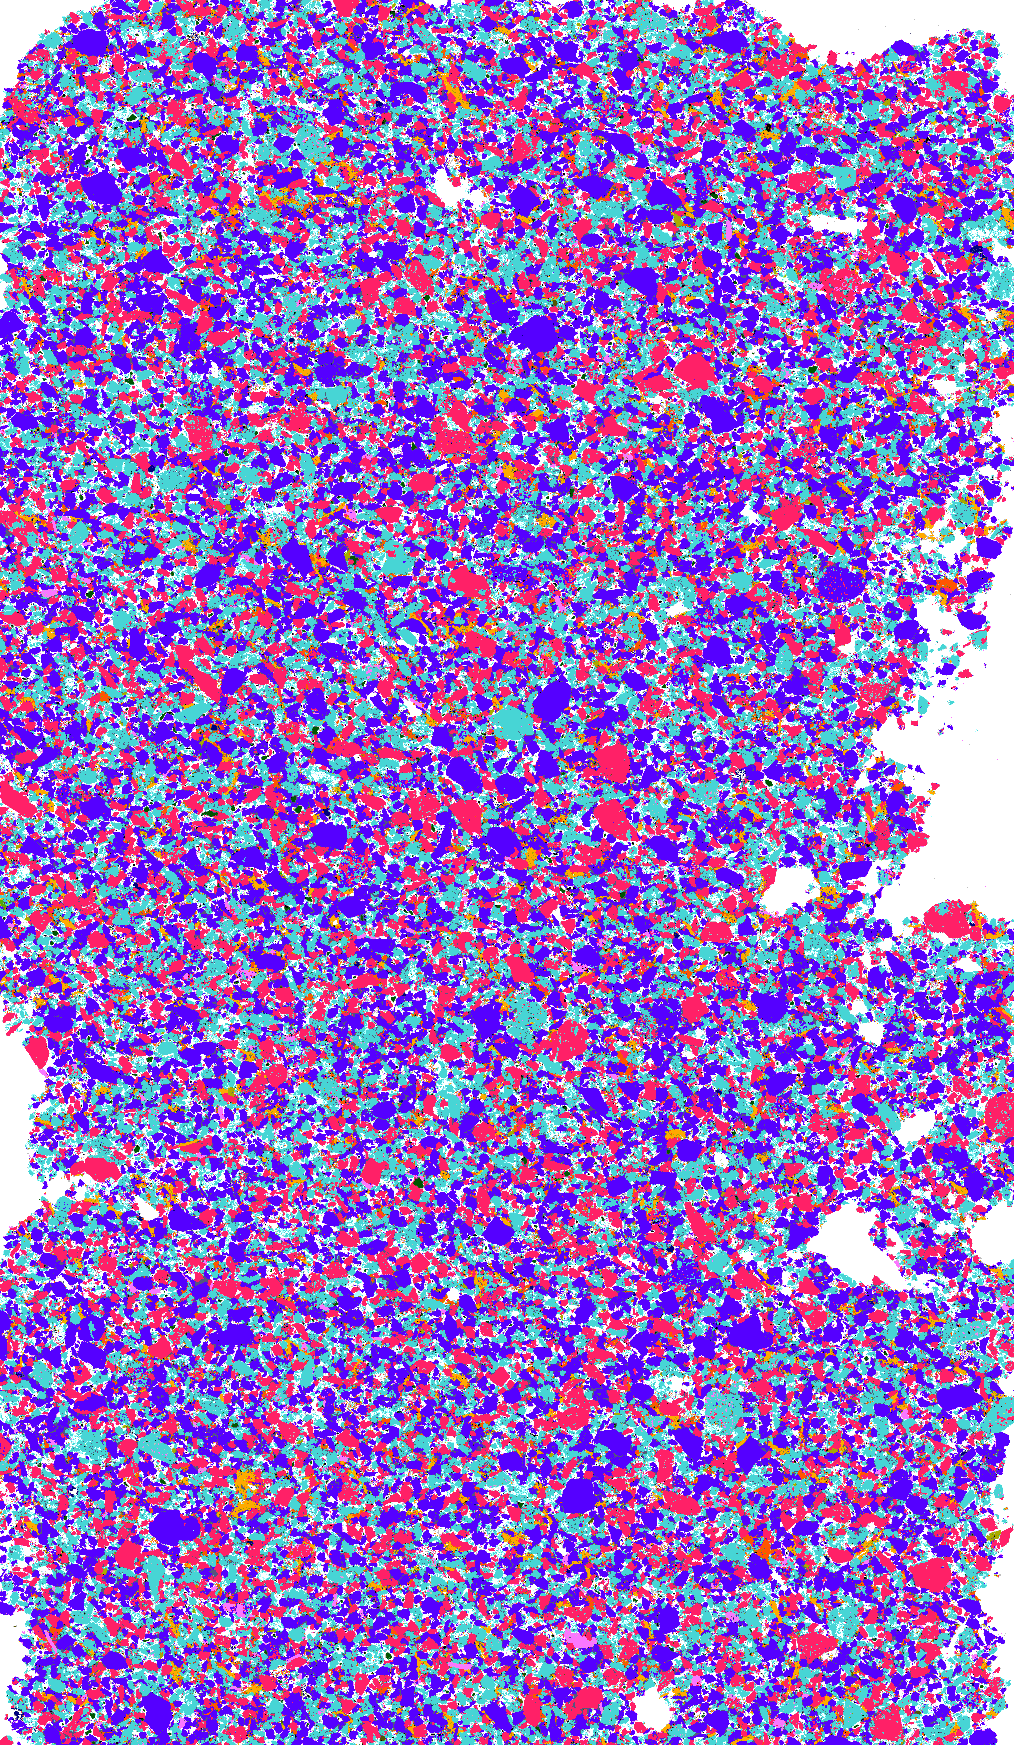

In [62]:
labels